In [1]:
%cd ..
%pwd
import torch_geometric
import torch
import networkx as nx
from networkx import DiGraph
from typing import Optional, List, Any, Tuple
from torch_geometric.utils.convert import from_networkx
from heapq import heapify
import random
import torch.nn as nn

/home/tekne/Oxford/ATML/Project/ggs-nn-model


In [2]:
def parent(i: int) -> Optional[int]:
    if i <= 0:
        return None
    return (i - 1) // 2

def is_heap(l) -> bool:
    for (i, e) in enumerate(l):
        p = parent(i)
        if p is not None and l[p] > e:
            return False
    return True

In [3]:
TOKEN_DIM = 1
MAX_LEN = 32

In [4]:
def make_array(min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.4) -> Tuple[List[int], bool]:
    result = []
    n = random.randint(min_len, max_len)
    for i in range(0, n):
        result.append(random.random())
    if random.random() < p_heapify: 
        heapify(result)
        result_is_heap = True
    else:
        result_is_heap = is_heap(result)
    return (torch.tensor(result).view(n, -1), result_is_heap)

In [5]:
for i in range(0, 5):
    arr = make_array()
    print(f"Example {i} has shape {tuple(arr[0].shape)} and {'is' if arr[1] else 'is not'} a heap")

Example 0 has shape (10, 1) and is not a heap
Example 1 has shape (20, 1) and is not a heap
Example 2 has shape (23, 1) and is not a heap
Example 3 has shape (9, 1) and is a heap
Example 4 has shape (17, 1) and is not a heap


In [6]:
def is_heapgraph(graph):
    for n, nbrs in graph.adj.items():
        for nbr in nbrs:
            if parent(nbr) != n:
                return False
    return True


def heapgraph(n: int) -> DiGraph:
    result = DiGraph()
    result.add_nodes_from(range(0, n))
    result.add_edges_from(
        (parent(i), i) for i in range(0, n) if parent(i) is not None
    )
    assert is_heapgraph(result)
    return result

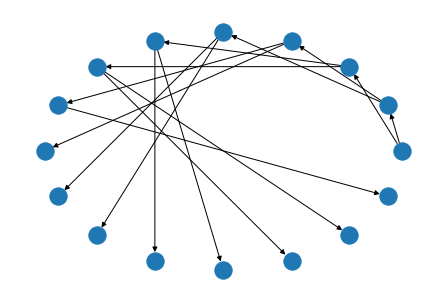

In [7]:
import matplotlib.pyplot as plt
nx.draw_circular(heapgraph(16))

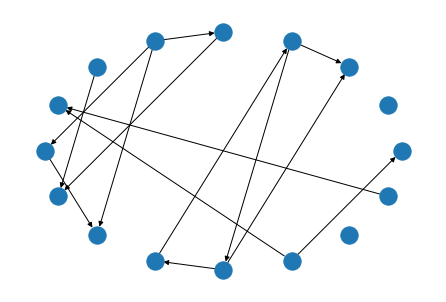

In [8]:
nx.draw_circular(nx.erdos_renyi_graph(16, 1/17, directed=True))

In [9]:
def make_datapoint(min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.75, p_heap_graph: float = 0.75, and_y: bool = True) -> List[int]:
    (nodes, is_heap) = make_array(min_len, max_len, p_heapify)
    n = nodes.shape[0]
    if random.random() < p_heap_graph: 
        graph = heapgraph(n)
        is_hg = True
    else:
        graph = nx.erdos_renyi_graph(n, 1/(n + 1), directed=True)
        is_hg = is_heapgraph(graph)
    
    data = from_networkx(graph)
    
    # Dumb edge case for when the number of edges is 0. Open an issue for torch_geometric?
    if data.edge_index.dtype != torch.long:
        data.edge_index = torch.zeros((2, 0), dtype=torch.long)

    assert data.edge_index.dtype == torch.long

    data.x = nodes
    if and_y:
        data.y = torch.tensor([float(is_heap and is_hg)])
    else:
        data.y = torch.tensor([
            float(is_heap),
            float(is_hg)
        ])

    return data

In [10]:
data = make_datapoint()
data

Data(edge_index=[2, 9], x=[10, 1], y=[1])

In [11]:
def generate_data(n: int, min_len: int = 1, max_len: int = MAX_LEN, p_heapify: float = 0.75, p_heap_graph: float = 0.75):
    for _ in range(0, n):
        yield make_datapoint(min_len=min_len, max_len=max_len, p_heapify=p_heapify, p_heap_graph=p_heap_graph)

In [12]:
list(generate_data(10))

[Data(edge_index=[2, 3], x=[4, 1], y=[1]),
 Data(edge_index=[2, 14], x=[15, 1], y=[1]),
 Data(edge_index=[2, 25], x=[26, 1], y=[1]),
 Data(edge_index=[2, 3], x=[6, 1], y=[1]),
 Data(edge_index=[2, 2], x=[2, 1], y=[1]),
 Data(edge_index=[2, 17], x=[18, 1], y=[1]),
 Data(edge_index=[2, 20], x=[21, 1], y=[1]),
 Data(edge_index=[2, 2], x=[3, 1], y=[1]),
 Data(edge_index=[2, 30], x=[31, 1], y=[1]),
 Data(edge_index=[2, 28], x=[29, 1], y=[1])]

In [13]:
N_SAMPLES = 1000
TEST_SAMPLES = N_SAMPLES
BATCH_SIZE = 1000

training_data = list(generate_data(N_SAMPLES))
testing_data = list(generate_data(TEST_SAMPLES))

training_loader = torch_geometric.data.DataLoader(training_data, batch_size=BATCH_SIZE)
testing_loader = torch_geometric.data.DataLoader(testing_data, batch_size=BATCH_SIZE)

In [14]:
for i in range(0, 10):
    print(f"{training_data[i]} ==> {training_data[i].y}")

Data(edge_index=[2, 25], x=[26, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 16], x=[17, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 34], x=[32, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 1], x=[2, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 28], x=[29, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 0], x=[1, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 2], x=[6, 1], y=[1]) ==> tensor([0.])
Data(edge_index=[2, 30], x=[31, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 16], x=[17, 1], y=[1]) ==> tensor([1.])
Data(edge_index=[2, 12], x=[15, 1], y=[1]) ==> tensor([0.])


In [15]:
from ggnns.graph_level_ggnn import GraphLevelGGNN
from ggnns.cycle_data import *

In [16]:
HIDDEN_SIZE = 10

ggnn = GraphLevelGGNN(
    annotation_size=TOKEN_DIM,
    num_layers=3,
    gate_nn=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 1),
    hidden_size=HIDDEN_SIZE,
    final_layer=nn.Linear(2*TOKEN_DIM + HIDDEN_SIZE, 1)
).cuda()

In [17]:
optimizer = torch.optim.Adam(ggnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [18]:
ggnn.train()
epoch_losses = []
epoch_accs = []
batch_losses = []
test_losses = []
test_accs = []
for epoch in trange(0, 50):

    epoch_loss = 0.0
    count = 0
    correct = 0
    total = 0
    for data in training_loader:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        y = data.y.cuda()
        correct += ((out.view(-1) >= 0.5) == y).sum()
        total += y.view(-1).shape[-1]
        loss = criterion(out.view(-1), y)
        loss.backward()
        batch_losses.append(float(loss))
        epoch_loss += float(loss)
        count += 1
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss /= count
    epoch_losses.append(epoch_loss)
    epoch_accs.append(int(correct) / total)

    test_loss = 0.0
    count = 0
    correct = 0
    total = 0
    for data in testing_loader:
        out = ggnn(data.x.cuda(), data.edge_index.cuda(), data.batch.cuda())
        y = data.y.cuda()
        loss = criterion(out.view(-1), y)
        correct += ((out.view(-1) >= 0.5) == y).sum()
        total += y.view(-1).shape[-1]
        count += 1
        test_loss += float(loss)

    test_loss /= count
    test_losses.append(test_loss)
    test_accs.append(int(correct) / total)

100%|██████████| 50/50 [00:03<00:00, 12.70it/s]


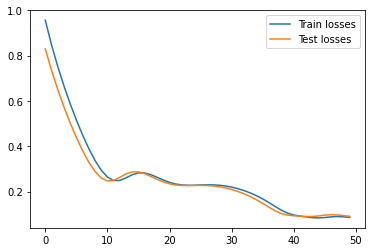

In [19]:
plt.plot(epoch_losses, label="Train losses")
plt.plot(test_losses, label="Test losses")
plt.legend()

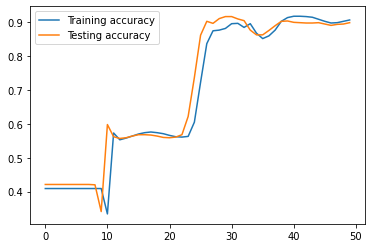

In [20]:
plt.plot(epoch_accs, label="Training accuracy")
plt.plot(test_accs, label="Testing accuracy")
plt.legend()

In [40]:
test_accs[-1]

0.952